In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

类别预测层

In [2]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    '''
    `num_inputs`：输入通道的数量，即特征图的通道数。
    `num_anchors`：每个特征图位置生成的锚框数量。
    `num_classes`：目标类别的数量。

     `out_channels=num_anchors * (num_classes + 1)`：输出通道数，
     即每个锚框的预测数量乘以（类别数 + 1）。
     这里的 `num_classes + 1` 表示每个锚框要预测 `num_classes` 个类别以及 1 个背景类。

    '''
    return nn.Conv2d(
        num_inputs,
        num_anchors * (num_classes + 1),
        kernel_size=3,
        padding=1
    )

边界框预测层

In [3]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

连接多尺度的预测

In [4]:
def forward(x, block):
    return block(x)

In [5]:
Y1 = forward(
    torch.zeros(
        (2, 8, 20, 20)
    ),
    cls_predictor(8, 5, 10)
)
Y1.shape

torch.Size([2, 55, 20, 20])

In [6]:
Y2 = forward(
    torch.zeros(
        (2, 16, 10, 10)
    ),
    cls_predictor(16, 3, 10)
)
Y2.shape

torch.Size([2, 33, 10, 10])

In [7]:
# 对单个预测结果张量进行扁平化处理
def flatten_pred(pred):
    '''
    `permute` 方法用于改变张量的维度顺序。
    假设 `pred` 的形状是 `(batch_size, channels, height, width)`，`permute(0, 2, 3, 1)` 将其变为 `(batch_size, height, width, channels)`。
    这一步的目的是将通道维度放到最后，方便后续操作。

    torch.flatten(..., start_dim=1)
    `flatten` 方法用于将张量展平。
    `start_dim=1` 表示从第1维（即 `batch_size` 之后的第一个维度）开始展平。
    这样会将 `height`、`width` 和 `channels` 这三个维度展平成一个单一的维度，
    使张量形状变为 `(batch_size, height * width * channels)`。

    '''
    return torch.flatten(
        pred.permute(0, 2, 3, 1),
        start_dim=1
    )

In [8]:
# 将多个预测结果张量在指定维度上拼接起来
def concat_preds(preds):
    '''
    [flatten_pred(p) for p in preds]
    
    - 使用列表推导式对 `preds` 列表中的每个张量 `p` 调用 `flatten_pred` 函数。
    - 这会生成一个新的列表，包含了每个经过扁平化处理的预测结果张量。

    torch.cat(..., dim=1)
    `cat` 方法用于沿指定维度拼接张量。
    `dim=1` 表示在第二个维度（即展平后的维度）上拼接。
    假设 `preds` 包含多个预测结果张量，最终的输出张量将把这些扁平化的张量沿着第一个维度拼接在一起。
    '''
    return torch.cat(
        [
            flatten_pred(p) for p in preds
        ],
        dim = 1
    )

'''
整体流程

1. `flatten_pred` 函数将每个预测结果张量的形状从 `(batch_size, channels, height, width)` 转换为 `(batch_size, height * width * channels)`。
2. `concat_preds` 函数将所有这些经过扁平化处理的张量在指定维度上拼接在一起，得到一个新的张量，形状为 `(batch_size, sum_of_all_height_width_channels)`，其中 `sum_of_all_height_width_channels` 是所有输入张量展平后的维度大小的总和。

这样处理的目的是将多个卷积层的预测结果整合在一起，便于后续的目标检测任务。
'''

'\n整体流程\n\n1. `flatten_pred` 函数将每个预测结果张量的形状从 `(batch_size, channels, height, width)` 转换为 `(batch_size, height * width * channels)`。\n2. `concat_preds` 函数将所有这些经过扁平化处理的张量在指定维度上拼接在一起，得到一个新的张量，形状为 `(batch_size, sum_of_all_height_width_channels)`，其中 `sum_of_all_height_width_channels` 是所有输入张量展平后的维度大小的总和。\n\n这样处理的目的是将多个卷积层的预测结果整合在一起，便于后续的目标检测任务。\n'

In [9]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

高和宽减半块

In [10]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                padding=1
            )
        )
        blk.append(
            nn.BatchNorm2d(
                out_channels
            )
        )
        blk.append(
            nn.ReLU()
        )
        in_channels = out_channels
    blk.append(
        nn.MaxPool2d(2)
    )
    return nn.Sequential(*blk)

'''
- `nn.Conv2d`：进行卷积运算，改变通道数和特征图的大小。
- `nn.BatchNorm2d`：进行批量归一化，加速训练并稳定网络。
- `nn.ReLU`：应用 ReLU 激活函数，引入非线性。
- `nn.MaxPool2d`：进行最大池化，下采样特征图。
'''

'\n- `nn.Conv2d`：进行卷积运算，改变通道数和特征图的大小。\n- `nn.BatchNorm2d`：进行批量归一化，加速训练并稳定网络。\n- `nn.ReLU`：应用 ReLU 激活函数，引入非线性。\n- `nn.MaxPool2d`：进行最大池化，下采样特征图。\n'

In [11]:
forward(
    torch.zeros(
        (2, 3, 20, 20)
    ),
    down_sample_blk(3, 10)
).shape

torch.Size([2, 10, 10, 10])

基本网络块

In [12]:
'''
`forward`将一个张量通过 `base_net` 网络结构，并打印其形状。
这是实现卷积神经网络(CNN)的一部分，通常用于计算机视觉任务，如目标检测
'''
def base_net():
    '''
    `blk = []`：初始化一个空列表 `blk`，用来存储各层网络块。
    `num_filters = [3, 16, 32, 64]`：定义每个卷积层的输入和输出通道数，分别为 3, 16, 32, 64。
    
    '''
    blk = []
    num_filters = [3, 16, 32, 64]
    '''
    `for i in range(len(num_filters) - 1)`：遍历 `num_filters` 列表，依次创建下采样块，并添加到 `blk` 列表中。
    
    `blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))`：
        将 `down_sample_blk` 函数生成的网络块添加到 `blk` 列表中。

    `return nn.Sequential(*blk)`：将 `blk` 列表中的所有网络块组合成一个 `nn.Sequential` 容器，并返回。
    `nn.Sequential` 是一个有序容器，神经网络的各层会按照添加的顺序依次执行。
    
    '''
    for i in range(
        len(num_filters) -1
    ):
        blk.append(
            down_sample_blk(
                num_filters[i],
                num_filters[i+1]
            )
        )
    return nn.Sequential(*blk)


In [13]:
forward(
    torch.zeros(
        (2, 3, 256, 256)
    ),
    base_net()
).shape

'''
通过 `base_net` 传递一个形状为 `(2, 3, 256, 256)` 的张量，我们需要了解每一层的输出形状：
- 第一层：输入 `(2, 3, 256, 256)`，输出 `(2, 16, 128, 128)`（假设 stride=2, padding=1 的卷积）
- 第二层：输入 `(2, 16, 128, 128)`，输出 `(2, 32, 64, 64)`
- 第三层：输入 `(2, 32, 64, 64)`，输出 `(2, 64, 32, 32)`

因此，最终输出的形状应该是 `(2, 64, 32, 32)`。
'''


'\n通过 `base_net` 传递一个形状为 `(2, 3, 256, 256)` 的张量，我们需要了解每一层的输出形状：\n- 第一层：输入 `(2, 3, 256, 256)`，输出 `(2, 16, 128, 128)`（假设 stride=2, padding=1 的卷积）\n- 第二层：输入 `(2, 16, 128, 128)`，输出 `(2, 32, 64, 64)`\n- 第三层：输入 `(2, 32, 64, 64)`，输出 `(2, 64, 32, 32)`\n\n因此，最终输出的形状应该是 `(2, 64, 32, 32)`。\n'

完整的模型

In [14]:
# `get_blk` 根据输入的索引 `i` 返回不同的块（block）。
def get_blk(i):
    if i==0:
        blk = base_net()
    elif i==1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return  blk

In [15]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    # 生成锚框。
    anchors = d2l.multibox_prior(
        Y, sizes=size, ratios=ratio
    )
    # 通过类别预测器生成类别预测。
    cls_preds = cls_predictor(Y)

    # 通过边界框预测器生成边界框预测。
    bbox_preds = bbox_predictor(Y)
    return (
        Y, anchors, cls_preds, bbox_preds
    )

In [16]:
'''
定义了 `sizes` 和 `ratios`，它们用于生成锚框。
每个 `sizes` 列表包含不同尺度的锚框。
`ratios` 包含不同宽高比的锚框。
`num_anchors` 表示每个位置生成的锚框数量。
'''
sizes = [
    [0.2, 0.272], 
    [0.37, 0.447], 
    [0.54, 0.619], 
    [0.71, 0.79],
    [0.88, 0.961]
]
ratios = [
    [1, 2, 0.5]
] * 5

num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [17]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        # 保存类别数量。
        self.num_classes = num_classes
        # idx_to_in_channels 一个列表，表示每个块的输入通道数。
        idx_to_in_channels = [64, 128, 128, 128, 128]
        '''
        
        '''
        for i in range(5):
            # 为模型添加 `blk_i` 属性，并通过 `get_blk(i)` 获得块。
            setattr(self, f'blk_{i}', get_blk(i))
            # 添加类别预测器。
            setattr(
                self, 
                f'cls_{i}', 
                cls_predictor(
                    idx_to_in_channels[i],
                    num_anchors,
                    num_classes
                )
            )
            # 添加边界框预测器。
            setattr(
                self, 
                f'bbox_{i}',
                bbox_predictor(
                    idx_to_in_channels[i],
                    num_anchors
                )
            )

    def forward(self, x):
        anchors, cls_preds, bbox_preds = [None] *5, [None] *5,[None] *5
        for i in range(5):
            # 对每个块进行前向传播，更新 `X`、`anchors`、`cls_preds` 和 `bbox_preds`。
            x, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                x, 
                getattr(
                    self, f'blk_{i}'
                ), 
                sizes[i],
                ratios[i],
                getattr(self, f'cls_{i}'),
                getattr(self, f'bbox_{i}')
            ) 
        # 将所有锚框拼接成一个张量。
        anchors = torch.cat(anchors, dim=1)
        # 将类别预测拼接成一个张量。
        cls_preds = concat_preds(cls_preds)
        
        # cls_preds.shape: torch.Size([32, 10888])
        # 调整类别预测的形状。
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0],
            -1,
            self.num_classes + 1
        )
        # cls_preds.shape: torch.Size([32, 5444, 2])
        
        # 将边界框预测拼接成一个张量。
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [18]:
net = TinySSD(num_classes=1)
x = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(x)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


训练模型

In [19]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [20]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(
    net.parameters(),
    lr=0.2,
    weight_decay=5e-4
)

定义损失函数和评价函数

In [21]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')


In [22]:
# 计算预测类别和边界框（bounding box）之间的损失
def calc_loss(
    cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks
):
    '''
    **参数说明**
    - `cls_preds`: 预测的类别，形状为 (batch_size, num_anchors, num_classes + 1)。
    - `cls_labels`: 真实的类别标签，形状为 (batch_size, num_anchors)。
    - `bbox_preds`: 预测的边界框，形状为 (batch_size, num_anchors, 4)。
    - `bbox_labels`: 真实的边界框标签，形状为 (batch_size, num_anchors, 4)。
    - `bbox_masks`: 边界框掩码，用于只计算有效锚框的损失，形状为 (batch_size, num_anchors, 4)。
    
    **计算类别损失**
    - `cls_preds.reshape(-1, num_classes)` 将 `cls_preds` 重塑为 (batch_size * num_anchors, num_classes) 的形状，以适应 `CrossEntropyLoss` 损失函数。
    - `cls_labels.reshape(-1)` 将 `cls_labels` 重塑为 (batch_size * num_anchors) 的形状。
    - `cls_loss(cls_preds.reshape(-1, num_classes), cls_labels.reshape(-1))` 计算每个锚框的类别损失。
    - `reshape(batch_size, -1).mean(dim=1)` 将损失恢复到 (batch_size, num_anchors) 的形状，并对每个批次中的锚框损失取平均值，得到每个批次的平均类别损失 `cls`。

    **计算边界框损失**
    - `bbox_preds * bbox_masks` 和 `bbox_labels * bbox_masks` 用于只计算有效锚框的边界框损失。
    - `bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)` 计算每个锚框的边界框损失。
    - `mean(dim=1)` 对每个批次中的锚框损失取平均值，得到每个批次的平均边界框损失 `bbox`。
  
    '''
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(
        cls_preds.reshape(-1, num_classes),
        cls_labels.reshape(-1)
    ).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(
        bbox_preds * bbox_masks,
        bbox_labels * bbox_masks
    ).mean(dim=1)

    return cls + bbox

In [23]:
def cls_eval(cls_preds, cls_labels):
    '''
    **参数说明**
    由于类别预测结果放在最后一维，argmax 需要指定最后一维
    - `cls_preds`: 预测的类别，形状为 (batch_size, num_anchors, num_classes + 1)。
    - `cls_labels`: 真实的类别标签，形状为 (batch_size, num_anchors)。

    **预测类别**
    - `cls_preds.argmax(dim=-1)` 在最后一维（类别维度）上取最大值的索引，这个索引就是预测的类别。
    - 这将 `cls_preds` 从形状 (batch_size, num_anchors, num_classes + 1) 转换为 (batch_size, num_anchors)，与 `cls_labels` 的形状相同。

    **类型转换**:
    - `cls_preds.argmax(dim=-1).type(cls_labels.dtype)` 将预测的类别索引转换为与 `cls_labels` 相同的数据类型。

    **准确度计算**:
    - `(cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels)` 生成一个布尔张量，表示预测的类别是否与真实标签匹配。
    - `.sum()` 计算匹配的总数。
    - `float()` 将结果转换为浮点数。

    最后返回预测正确的类别数目。
    '''
    
    return float(
        (
            cls_preds.argmax(dim=-1).type(
                cls_labels.dtype
            ) == cls_labels
        ).sum()
    )

In [24]:
'''
**参数说明**:
- `bbox_preds`: 预测的边界框，形状为 (batch_size, num_anchors, 4)。
- `bbox_labels`: 真实的边界框标签，形状为 (batch_size, num_anchors, 4)。
- `bbox_masks`: 边界框掩码，用于只计算有效锚框的损失，形状为 (batch_size, num_anchors, 4)。

**计算绝对误差**:
- `bbox_labels - bbox_preds` 计算预测边界框与真实边界框之间的差异。
- `torch.abs((bbox_labels - bbox_preds) * bbox_masks)` 计算每个锚框的绝对误差，并使用掩码 `bbox_masks` 来只考虑有效的锚框。

**误差求和**:
- `.sum()` 计算所有锚框上的绝对误差总和。
- `float()` 将结果转换为浮点数。

该函数返回边界框预测的总绝对误差。
'''
def bbox_eval(bbox_preds, bbox_labes, bbox_masks):
    return float(
        (
            torch.abs(
                (bbox_labels - bbox_preds) * bbox_masks
            )
        ).sum()
    )

'''
`bbox_masks` 是在训练过程中生成的一种掩码，用于忽略无效或不相关的锚框，仅计算有效锚框的损失。
具体来说，它帮助在计算边界框损失时，只关注那些有实际目标的锚框。

生成 `bbox_masks` 的过程：

`bbox_masks` 通常是在通过 `d2l.multibox_target` 函数生成的，
该函数负责为每个锚框标注类别和偏移量，同时生成掩码。下面是一个简单的解释过程：

**锚框匹配**：
- 在目标检测中，我们有一组预定义的锚框（anchor boxes）。
- 每个锚框会与真实的目标边界框进行匹配，确定哪些锚框是有效的（即与某个真实目标有较高的重叠度）。

**生成标签和掩码**：
- 对于每个锚框，`d2l.multibox_target` 函数会生成相应的类别标签和边界框回归标签。
- 同时，它会生成一个掩码 `bbox_masks`，指示哪些锚框是有效的。掩码的作用是：对于无效的锚框（比如那些与真实目标没有足够重叠的锚框），我们不希望其对损失计算产生影响。

**掩码的形状和作用**：
- `bbox_masks` 的形状为 `(batch_size, num_anchors, 4)`，与 `bbox_preds` 和 `bbox_labels` 形状相同。
- 掩码值为0的部分表示无效锚框，在计算损失时会被忽略。掩码值为1的部分表示有效锚框，会参与损失计算。

`bbox_masks` 的作用：
 
在上述代码中，`bbox_masks` 被用于元素级乘法，确保只有有效锚框的预测和标签被用于计算边界框损失。
无效锚框的损失被掩盖（乘以0），从而不影响总体损失的计算。

总结：

- `bbox_masks` 是一种掩码，用于在计算边界框损失时忽略无效锚框。
- 它由 `d2l.multibox_target` 函数根据锚框和真实目标的匹配情况生成。
- 掩码确保只有有效锚框的预测和标签用于损失计算，从而提高训练过程的准确性和效率。

'''

'\n`bbox_masks` 是在训练过程中生成的一种掩码，用于忽略无效或不相关的锚框，仅计算有效锚框的损失。\n具体来说，它帮助在计算边界框损失时，只关注那些有实际目标的锚框。\n\n生成 `bbox_masks` 的过程：\n\n`bbox_masks` 通常是在通过 `d2l.multibox_target` 函数生成的，\n该函数负责为每个锚框标注类别和偏移量，同时生成掩码。下面是一个简单的解释过程：\n\n**锚框匹配**：\n- 在目标检测中，我们有一组预定义的锚框（anchor boxes）。\n- 每个锚框会与真实的目标边界框进行匹配，确定哪些锚框是有效的（即与某个真实目标有较高的重叠度）。\n\n**生成标签和掩码**：\n- 对于每个锚框，`d2l.multibox_target` 函数会生成相应的类别标签和边界框回归标签。\n- 同时，它会生成一个掩码 `bbox_masks`，指示哪些锚框是有效的。掩码的作用是：对于无效的锚框（比如那些与真实目标没有足够重叠的锚框），我们不希望其对损失计算产生影响。\n\n**掩码的形状和作用**：\n- `bbox_masks` 的形状为 `(batch_size, num_anchors, 4)`，与 `bbox_preds` 和 `bbox_labels` 形状相同。\n- 掩码值为0的部分表示无效锚框，在计算损失时会被忽略。掩码值为1的部分表示有效锚框，会参与损失计算。\n\n`bbox_masks` 的作用：\n \n在上述代码中，`bbox_masks` 被用于元素级乘法，确保只有有效锚框的预测和标签被用于计算边界框损失。\n无效锚框的损失被掩盖（乘以0），从而不影响总体损失的计算。\n\n总结：\n\n- `bbox_masks` 是一种掩码，用于在计算边界框损失时忽略无效锚框。\n- 它由 `d2l.multibox_target` 函数根据锚框和真实目标的匹配情况生成。\n- 掩码确保只有有效锚框的预测和标签用于损失计算，从而提高训练过程的准确性和效率。\n\n'

模型训练

class err 3.25e-03, bbox mae 3.14e-03
5929.2 examples/sec on cuda:0


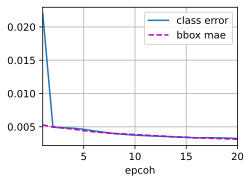

In [25]:
'''
- `num_epochs`: 训练的轮数，设定为20。
- `timer`: 用于计时，计算每秒处理的样本数。
- `animator`: 用于可视化训练过程中的损失变化情况。
- `net = net.to(device)`: 将模型移动到指定的设备（如 GPU）上。
'''
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(
    xlabel='epcoh', xlim=[1, num_epochs], legend=['class error', 'bbox mae']
)

net = net.to(device)

for epoch in range(num_epochs):
    # 训练精度的和，训练精确度的和中的示例数
    # 创建一个用于累加评估指标的工具，记录四个指标（训练精度的和、训练样本数、绝对误差的和、绝对误差的样本数）。
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度锚框，并预测每个锚框的类别和边界框偏移量。
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和边界框偏移量，同时生成掩码。
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(
            cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks
        )
        l.mean().backward()
        trainer.step()
        # 更新累加器，记录当前批次的评估结果。
        metric.add(
            cls_eval(cls_preds, cls_labels),
            cls_labels.numel(),
            bbox_eval(bbox_preds, bbox_labels, bbox_masks),
            bbox_labels.numel()
        )
    cls_err, bbox_mae = 1 -metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))

'''


'''
# 打印最终的分类错误率和边界框平均绝对误差。
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')

# 打印每秒处理的样本数。
print(
    f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
    f'{str(device)}'
)
        
        
        

预测目标

In [26]:
'''
**`.unsqueeze(0)`**:
- `unsqueeze(0)` 在第0维（即最前面）增加一个维度，使张量的形状从 `(C, H, W)` 变为 `(1, C, H, W)`。
- 这是因为模型通常期望输入的张量具有批次维度（batch dimension），即 `(batch_size, C, H, W)`，这里的 `batch_size` 为1。
'''
X = torchvision.io.read_image('./img/banana.png').unsqueeze(0).float()
'''
**`X.squeeze(0)`**:
- `squeeze(0)` 移除第0维，即批次维度。这样张量的形状从 `(1, C, H, W)` 恢复为 `(C, H, W)`。

**`.permute(1, 2, 0)`**:
- `permute(1, 2, 0)` 重新排列张量的维度顺序，从 `(C, H, W)` 变为 `(H, W, C)`。
- 这是因为图像显示函数通常期望的输入格式是 `(height, width, channels)`。

**`.long()`**:
- `long()` 将张量的数据类型转换为长整型（`torch.int64`）。
- 这一步通常是为了兼容某些后续处理或显示函数，但这里转换为长整型可能没有特别必要。

'''
img = X.squeeze(0).permute(1, 2, 0).long()

'''

总结：

- 第一行代码从文件中读取图片，增加批次维度并将数据类型转换为浮点型，以适应模型输入的要求。
- 第二行代码移除批次维度，重新排列张量维度顺序以便于显示，并将数据类型转换为长整型。

这两行代码共同完成了图像数据的加载和预处理，为模型预测和结果显示做了准备。
'''

'\n\n总结：\n\n- 第一行代码从文件中读取图片，增加批次维度并将数据类型转换为浮点型，以适应模型输入的要求。\n- 第二行代码移除批次维度，重新排列张量维度顺序以便于显示，并将数据类型转换为长整型。\n\n这两行代码共同完成了图像数据的加载和预处理，为模型预测和结果显示做了准备。\n'

In [27]:
'''
用于预测目标检测模型输出的函数

- **`F.softmax(cls_preds, dim=2)`**:
  - 对类别预测结果 `cls_preds` 的最后一维（第2维）应用 softmax 函数，将其转换为概率。
- **`.permute(0, 2, 1)`**:
  - 调整张量的维度顺序，从 `(batch_size, num_anchors, num_classes + 1)` 变为 `(batch_size, num_classes + 1, num_anchors)`，以便后续处理。

进行非极大值抑制 (NMS)：
- **`d2l.multibox_detection(cls_probs, bbox_preds, anchors)`**:
  - 使用 `d2l` 提供的 `multibox_detection` 函数，基于类别概率 `cls_probs`、边界框预测 `bbox_preds` 和锚框 `anchors` 进行检测。
  - 该函数通常会进行非极大值抑制（NMS），以过滤掉多余的检测框，并返回最终的检测结果 `output`。

筛选有效检测结果：
- **`idx = [i for i, row in enumerate(output[0]) if row[0] != -1]`**:
  - 遍历 `output` 中第一个批次的检测结果（`output[0]`）。
  - 筛选出有效的检测结果，即那些类别索引（`row[0]`）不等于 -1 的行（-1 通常表示无效或背景类别）。

 `output[0]` 表示取出批次中的第一张图片的检测结果。

- **`return output[0, idx]`**:
  - 返回有效检测结果的子集。
  - `idx` 是一个列表，包含有效检测结果的索引。
  - `output[0, idx]` 返回的是批次中第一张图片的有效检测结果。

'''
def predict(x):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(
        cls_probs, bbox_preds, anchors
    )
    idx = [
        i for i, row in enumerate(output[0]) if row[0] != -1
    ]
    return output[0, idx]


In [28]:
output = predict(x)

In [29]:
def display(img, output, threshold):
    d2l.set_figsize((5,5))
    fig = d2l.plt.imshow(img)
    # 每个检测框包含 6 个值：
    # `[类别索引, 置信度, xmin, ymin, xmax, ymax]`
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [
            row[2:6] * torch.tensor(
                (w, h, w, h),
                device=row.device
            )
        ]
        d2l.show_bboxes(
            fig.axes, bbox, '%.2f' % score, 'w'
        )

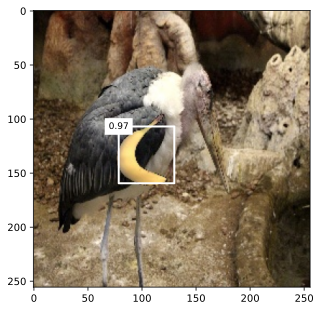

In [30]:
display(img, output.cpu(), threshold=0.9)